In [ ]:
import ROOT
import uproot
from IPython.display import display

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import subprocess
import os

cling::DynamicLibraryManager::loadLibrary(): libGLU.so.1: cannot open shared object file: No such file or directory
Error in <AutoloadLibraryMU>: Failed to load library /cvmfs/sft.cern.ch/lcg/releases/ROOT/6.28.06-97f54/x86_64-el9-gcc11-opt/lib/libEve.socling JIT session error: Failed to materialize symbols: { (main, { _ZeqRK7TStringRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE }) }


Welcome to JupyROOT 6.28/06


- Study gnom structure
- Merge gnoms from different runs
- Merge gnoms from same run (when available)
- Prepare 2D gaussian fits to 2D hitmap in gnom
- Clean up in tunnel - DONE

In [ ]:
base_path  = "/eos/project-t/twocryst/data/tft/gnamRootFiles/"
folder_list = ['gnam_1TFT', 'gnam_2TFT', 'gnam_5TFT', 'gnamTFT']

In [62]:
def get_histograms_root(file_name, folder="", hist_name=""):
    if folder=='shift':
        folder_name = "SHIFT/RP_5"
    elif folder=='expert':
        folder_name = "EXPERT/RP_5"

    root_file = ROOT.TFile.Open(file_name)
    directory = root_file.Get(folder_name)
    hist = directory.Get(hist_name)
    if not hist:
        print("Error: Histogram not found.")
    else:
        canvas = ROOT.TCanvas("canvas2", "Histogram Canvas", 800, 600)
        hist.Draw("COLZ")
        canvas.Update()
        canvas.SaveAs("tmp.png")  # Save the histogram as a PNG
        display(Image(filename="tmp.png"))  # Show the image in Jupyter

In [57]:
def get_histogram_uproot(file, folder="", hist_name=""):
    file = uproot.open(file)
    return file[folder]['RP_5'][hist_name]

In [65]:
def plot_MAPMTs_activity(hist, save=False):
    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 
    values = hist.values() 
    fig, ax = plt.subplots(figsize=(8, 6))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.set_xlabel("Location", fontsize=14)
    ax.set_ylabel("Location", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("MAPMTs activity / run " + run_number, fontsize=16)
    ticks = np.arange(5, 50, 5)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save:
        plt.savefig("./Plots/MAPMTs_activity_run_" + run_number + ".png")


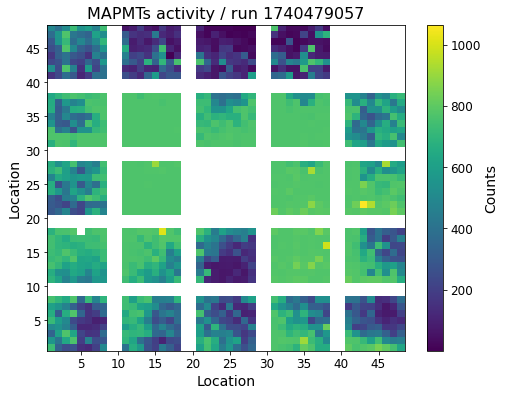

In [128]:
plot_MAPMTs_activity(get_histogram_uproot("./merged_gnams/TOTAL_gnam_1740479057.root", "EXPERT", "MAPMTs_activity"), save = True)

In [85]:
def plot_sumActiveLayers(hist, save=False):

    bin_edges = hist.axis(0).edges()  
    bin_values = hist.values()  
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(bin_centers, bin_values, width=np.diff(bin_edges), align="center")

    ax.set_xlabel("Number of active layers per event", fontsize=14)
    ax.set_ylabel("Events", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("Sum of active layers / run " + run_number, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ticks = np.arange(0, 22, 2)
    ax.set_xticks(ticks)

    num_entries = np.sum(bin_values)
    edges = bin_edges[:-1] 
    mean = np.sum(edges* bin_values) / num_entries
    variance = np.sum(bin_values * (edges - mean) ** 2) / num_entries
    std_dev = np.sqrt(variance)

    legend_text = f"Entries: {num_entries}\nMean: {mean:.2f}\nStd Dev: {std_dev:.2f}"
    ax.text(0.6, 0.95, legend_text, ha="right", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    if save:
        plt.savefig("./Plots/MAPMTs_activity_run_" + run_number + ".png")

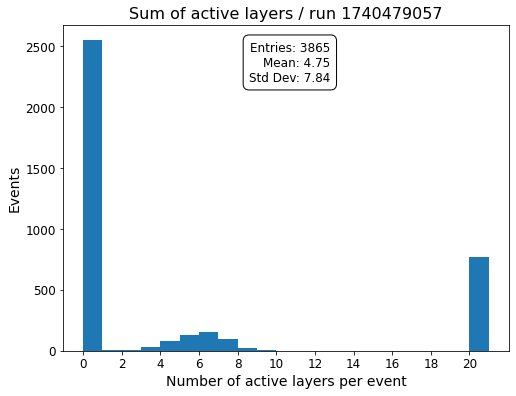

In [129]:
plot_sumActiveLayers(get_histogram_uproot("./merged_gnams/TOTAL_gnam_1740479057.root", "SHIFT", "sumActiveLayers"), save = True)

In [131]:
! ls /eos/project-t/twocryst/data/tft/gnamRootFiles/gnamTFT

gnam_1740564527.root  gnam_1741117188.root  gnam_1741121756.root
gnam_1740841190.root  gnam_1741119259.root
gnam_1741103650.root  gnam_1741120798.root


In [ ]:
number = 1741120798

In [134]:
def merge_gnams_python(number):
    base_path  = "/eos/project-t/twocryst/data/tft/gnamRootFiles/"
    folder_list = ['gnam_1TFT', 'gnam_2TFT', 'gnam_5TFT', 'gnamTFT']
    run_list = ['hadd', '-f', f'./merged_gnams/TOTAL_gnam_{number}.root']
    for folder in folder_list:
        path = base_path  + folder +f'/gnam_{number}.root'
        if os.path.exists(path):
            run_list.append(path)
        else:
            print(f"File {path} not found.")
            continue
    subprocess.run(run_list)


In [122]:
number = 1741103650

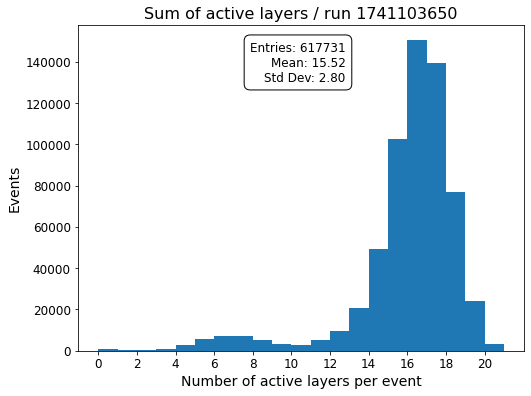

In [132]:
plot_sumActiveLayers(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{number}.root", "SHIFT", "sumActiveLayers"))

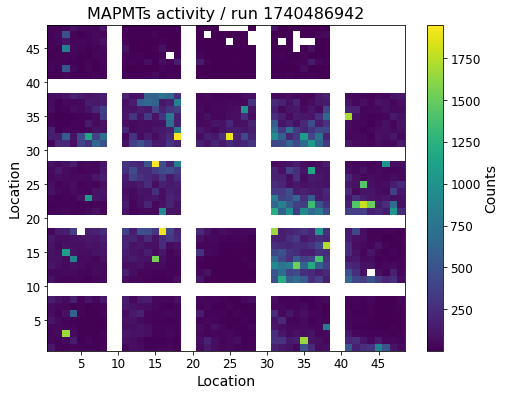

In [136]:
plot_MAPMTs_activity(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{1740486942}.root", "EXPERT", "MAPMTs_activity"))

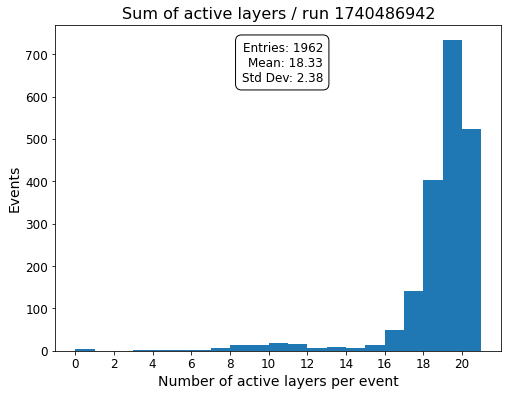

In [137]:
plot_sumActiveLayers(get_histogram_uproot(f"./merged_gnams/TOTAL_gnam_{1740486942}.root", "SHIFT", "sumActiveLayers"))

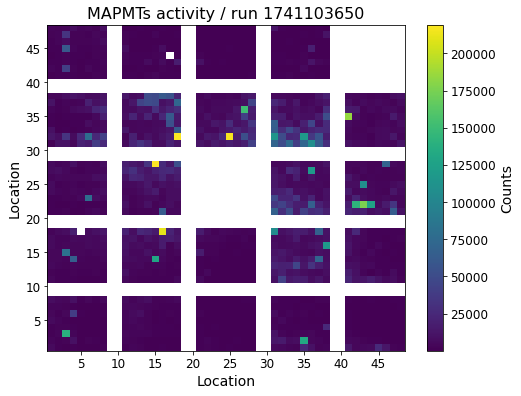

In [92]:
plot_MAPMTs_activity(get_histogram_uproot(base_path+'gnam_1TFT/gnam_1741103650.root', "EXPERT", "MAPMTs_activity"))

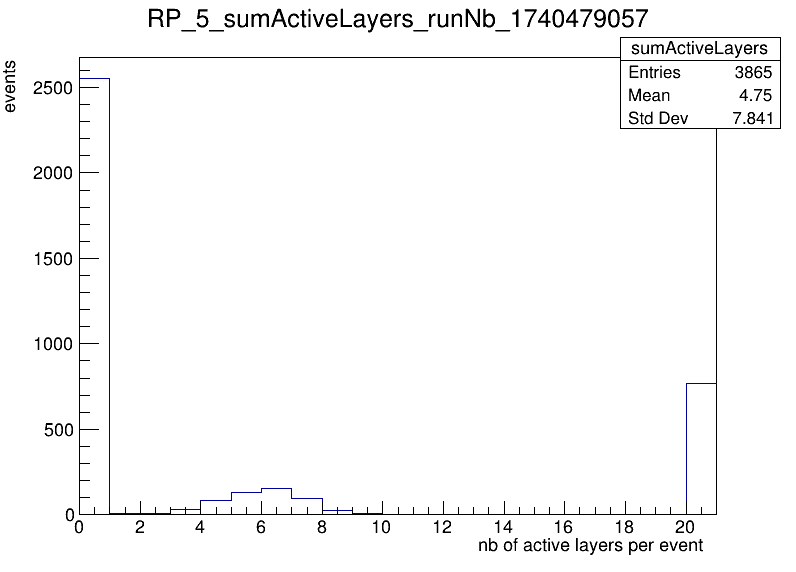

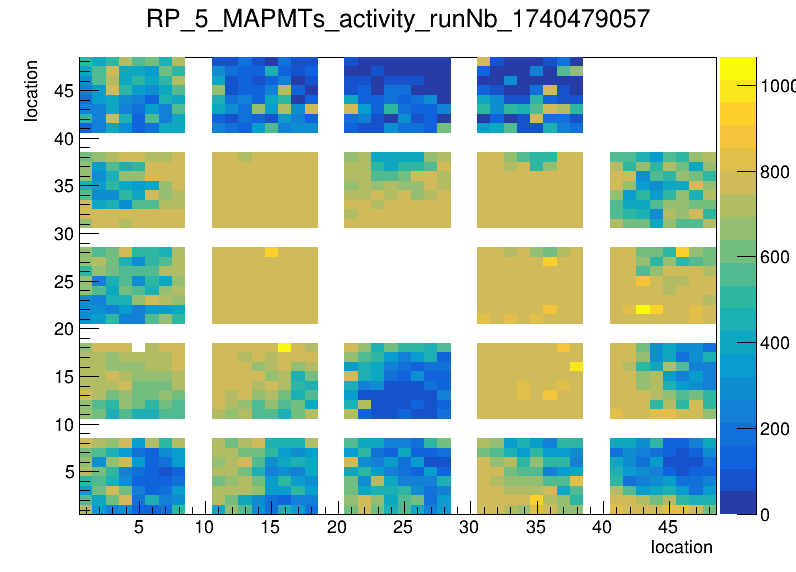

Info in <TCanvas::Print>: png file tmp.png has been created
Info in <TCanvas::Print>: png file tmp.png has been created


In [127]:
get_histograms_root("./merged_gnams/TOTAL_gnam_1740479057.root", folder="shift", hist_name="sumActiveLayers")
get_histograms_root("./merged_gnams/TOTAL_gnam_1740479057.root", folder="expert", hist_name="MAPMTs_activity")

In [ ]:
"""
some ROOT commands

TFile* input_root_file = TFile::Open("gnam_1740479057.root");
TDirectory* directory = (TDirectory*) input_root_file->Get("SHIFT/RP_5");
TH1* hist = (TH1*) directory->Get("sumActiveLayers");
hist->Draw();
merged_hist = (TH1*) hist->Clone();
merged_hist->Add(hist)
"""